# Facilities adherence to Image gently guidelines

ImageGently (https://www.imagegently.org/) is an initiaitve which aims to "through advocacy, improve safe and effective imaging care of children worldwide."
Specifically ImageGently aims to have practitioners tailor their imaging choices to minimize radiation burden to childern and young people by making specific choices in the imaging process. Some of these choices are to (1) tolerate higher noise scans in favor of lower doses, to (2) select lower tube KvP for scans in young people.

With this section we aim to assess whether there is a significant difference between the scan CTDI vol and the KVP between the Adult and Pediatric cases for the facilities.

We'll define pediatric cases as all those cases which are below age 18. And we will consider age groups as defined by the bins that are in the data that we have via Imalogix. Then we a Kruskall Wallis test on the CTDI vol, and the KVP, max mA, and pitch in the differnent age groups to see if there is a difference. Then we compare the median values of the distributions to ensure that the difference is in the correct direction (pitch should be higher, mA and kVp and CTDIvol should be lower)

## Directions:

1) Set the parameters:
        
        showIQ: Whether or not to show the Image Quality features on the plot. If you change this to True you mush make m*n>=6
        
        percentilReported: What is the reported percentile of the parameter histograms
 
        protoType = 'Abd-Pelvis' or, 'Chest': Determines which of the type of protocols the analysis will show for.

        minNumDataPoints = 11: For this anaylsis N>11 is used, but in principle anything can be selected
        
2) Run all the code:
    shift + enter in each cell

In [1]:
# showIQ: Whether or not to show the Image Quality features on the plot. If you change this to True you mush make m*n>=6
showIQ = False

# percentilReported: What is the reported percentile of the parameter histograms
percentilReported = 50

# protoType = 'Abd-Pelvis' or, 'Chest': Determines which of the type of protocols the analysis will show for.
protoType = 'Abd-Pelvis'
protoType = 'Chest'

# minNumDataPoints = 11: For this anaylsis N>11 is used, but in principle anything can be selected
minNumDataPoints = 11

# whichPhase = 1: For this analysis we only want to use one, (the first) phase of the scan to get the non-contrast exams
# If we want to use all, then select -1
whichPhase = 1

# OutputFile
writeToFile = False
 


In [2]:
# Import the packages
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score

import seaborn as sns



In [3]:
# Load Data -- This might take a long time so we might wanna try and do it just once
## Load the CSV

path = "/Volumes/CLINIC/Imalogix/ImalogixPlatformData_TransfersAndAnalysis/PediatricRadiologyStudy/pedRadiology_v1.xlsx"
prop_df = pd.read_excel(path,header = 0,sheet_name=None)

path_phantoms = "/Volumes/CLINIC/Imalogix/ImalogixPlatformData_TransfersAndAnalysis/AllData_RSNA/phantoms_for_all_scans.xlsx"
phantom_od = pd.read_excel(path_phantoms,header = 0,sheet_name=None)

path_scanorders = "/Users/taylorsmith/Documents/Python/ImalogixProject/SmallImalogixProject/pedRadiology_ImageGently/iqdb_scan_order.xlsx"
scanorders_od = pd.read_excel(path_scanorders,header = 0,sheet_name=None)


In [4]:
# Get the list of the sheets to make sure they're going in the right order
sheetList = list()
for i in prop_df.keys():
    sheetList.append(i)
    
print('Check to make sure that the dates are in order or this will be a problem with the resolution and location and centering orders:')
print(sheetList)
print('\n If there is an error in the order, make sure to correct')

# Concatenate all the sheets to make the full dataset-- missing res, centering, location
#data_df = (pd.concat(prop_df,sort=False)).reset_index(level=0, drop=False).rename(index=str, columns={"level_0":"WhichTransfer"})
data_df = pd.concat(prop_df,sort=False)
data_df = data_df.reset_index(drop=True)
#data_df = (pd.concat(prop_df,sort=False))

# Now get the dataset infor for resolution, centering, and location to add
from scipy.io import loadmat
rtdir = '/Volumes/CLINIC/Imalogix/ImalogixPlatformData_TransfersAndAnalysis/AllData_RSNA/imalogixdataanalysis/MATFiles_DataRSNA2018/'

# Want to make sure that the

# Read them into dictionaries and dataframes
res_dict = loadmat(rtdir+'RSNA_2018_MATLABVars_01112019_RES.mat')
res_df = pd.DataFrame({'RES':(res_dict['RES']).ravel()},index=np.arange(len(res_dict['RES'])))
res_df = res_df.reset_index(drop=True)

loc_dict = loadmat(rtdir+'RSNA_2018_MATLABVars_01112019_LOC.mat')
loc_df = pd.DataFrame({'LOC':(loc_dict['LOC']).ravel()},index=np.arange(len(loc_dict['LOC'])))
loc_df = loc_df.reset_index(drop=True)

offset_dict = loadmat(rtdir+'RSNA_2018_MATLABVars_01112019_OFFSET.mat')
offset_df = pd.DataFrame({'LatOffset':offset_dict['OFFSET'][:,0], 'APOffset':offset_dict['OFFSET'][:,1]},index=np.arange(len(offset_dict['OFFSET'])))
offset_df = offset_df.reset_index(drop=True)

# Make sure that only the new data makes it into the analysis, and that the loc, res, and offset line up appropriately when we drop all the cases that come before 07/02
loc_df = (loc_df.drop(np.arange(0,5664))).reset_index(drop=True)
res_df = (res_df.drop(np.arange(0,5664))).reset_index(drop=True)
offset_df = (offset_df.drop(np.arange(0,5664))).reset_index(drop=True)


# Put all of the data together
alldata_df= (pd.concat([data_df,res_df,loc_df,offset_df],sort=False,axis=1)).dropna(subset=['RES', 'z1_noisebody9_median'])
truealldata_df= (pd.concat([data_df,res_df,loc_df,offset_df],sort=False,axis=1))

# Merge the CTDIvol phantoms
phantom_df = phantom_od
phantom_df = pd.concat(phantom_df,sort=False)
phantom_df = phantom_df.reset_index(drop=True)
#truealldata_df  =pd.merge(truealldata_df,phantom_df,on=['iqdb_acquisition_id'],how='outer')
truealldata_df  =pd.merge(truealldata_df,phantom_df,on=['iqdb_acquisition_id'],how='left')
truealldata_df.fillna(np.NaN, inplace=True)

# Merge the scan orders
scanorders_df = scanorders_od
scanorders_df = pd.concat(scanorders_df,sort=False)
scanorders_df = scanorders_df.reset_index(drop=True)
truealldata_df  =pd.merge(truealldata_df,scanorders_df,on=['iqdb_acquisition_id'],how='left')
truealldata_df.fillna(np.NaN, inplace=True)

# Drop all the cases that come before 07/02
#truealldata_df = truealldata_df[truealldata_df.iqdb_acquisition_id>=75177].reset_index(drop=True)

# Make it into a numpy array


Check to make sure that the dates are in order or this will be a problem with the resolution and location and centering orders:
['2018_07_02', '2018_07_20', '2018_07_31', '2018_08_21', '2018_08_30', '2018_09_12', '2018_09_20', '2018_10_05', '2018_10_16', '2018_10_30', '2018_11_08', '2019_01_06']

 If there is an error in the order, make sure to correct


In [5]:
# Data preprocessing step to remove all series that are not the first image in the first acquisition
tmp_df = truealldata_df

if(not (whichPhase==-1)):
    tmp_df=tmp_df.loc[tmp_df.scan_number==whichPhase,:]

#Get rid of duplicates and take the first acquisition time
u,c = np.unique(tmp_df.StudyIuid,return_counts=True)
cnt = 0
for i in u[c>1]:
    #print((truealldata_df.loc[truealldata_df.StudyIuid==i,:]).ContentTime_min)
    foo = min((tmp_df.loc[tmp_df.StudyIuid==i,:]).ContentTime_min)
    bar = tmp_df[((tmp_df.StudyIuid==i) & ((tmp_df.ContentTime_min!=foo)))].index.values.tolist()
    #print('List of IDX to drop: '+str(bar))
    tmp_df = tmp_df.drop(bar)
    cnt = cnt+1
    
    if((cnt>999) & (cnt%1000 == 0)):
        print('Processing Study '+str(cnt)+' of '+str(len(u[c>1])))
              
truealldata_df = tmp_df 

Processing Study 1000 of 12913
Processing Study 2000 of 12913
Processing Study 3000 of 12913
Processing Study 4000 of 12913
Processing Study 5000 of 12913
Processing Study 6000 of 12913
Processing Study 7000 of 12913
Processing Study 8000 of 12913
Processing Study 9000 of 12913
Processing Study 10000 of 12913
Processing Study 11000 of 12913
Processing Study 12000 of 12913


In [88]:
truealldata_df = tmp_df

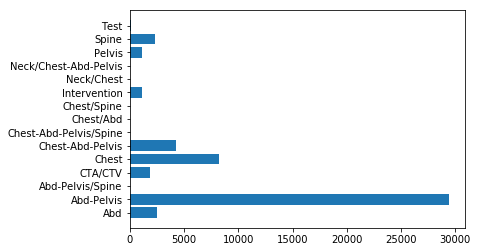

In [46]:
# Show how much of te dataset remains from the first acquisition images
uu,cc = np.unique(truealldata_df.z2_acquisition_protocol_type,return_counts=True)
plt.barh(uu,cc)
plt.show()


------ 
Location:  2


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:

Adult and 15-18 yrs  | Different Distributions? (KVP): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (mA): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Pitch): False
Adult and 15-18 yrs  | Different Distributions? (RevTime): False
Adult and 15-18 yrs  | Different Distributions? (CTDI): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (SSDE): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Size): True| Ped is lower: True



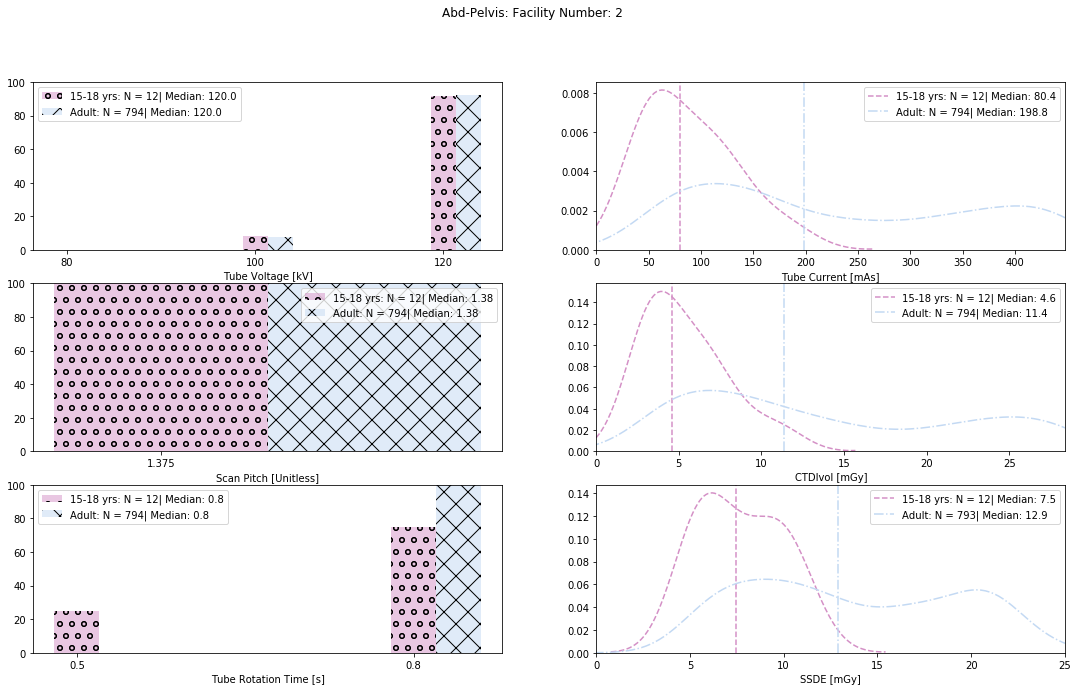


------ 
Location:  3

------ 
Location:  4


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationW

Adult and 15-18 yrs  | Different Distributions? (KVP): False
Adult and 15-18 yrs  | Different Distributions? (mA): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Pitch): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (RevTime): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (CTDI): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (SSDE): False| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Size): True| Ped is lower: True



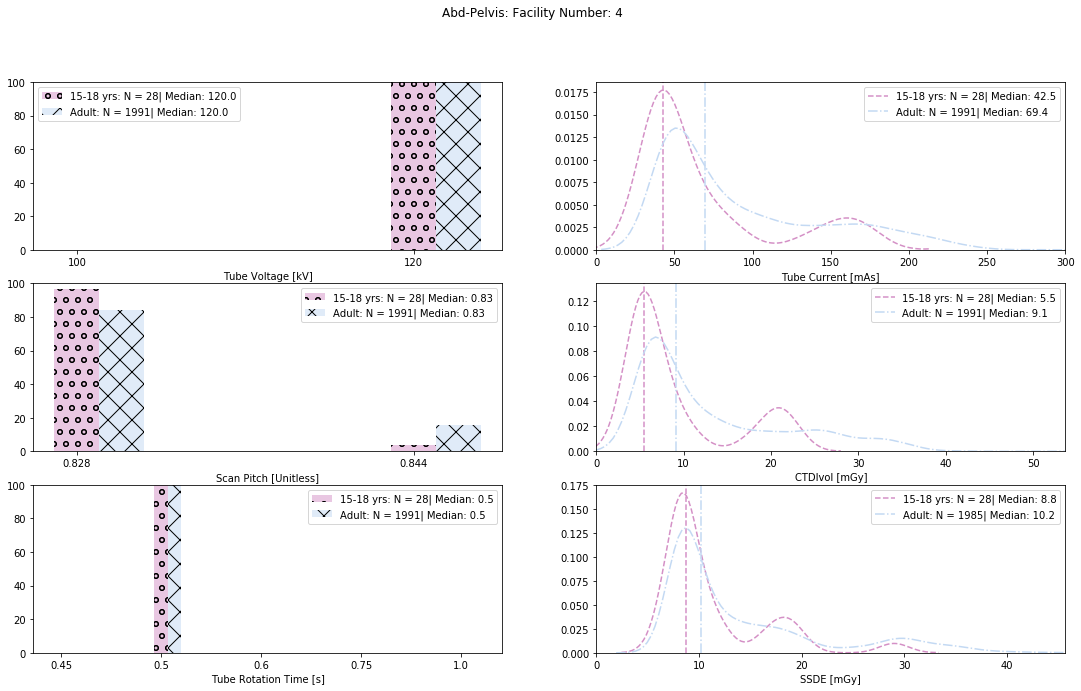


------ 
Location:  7

------ 
Location:  8

------ 
Location:  9

------ 
Location:  10

------ 
Location:  13

------ 
Location:  14

------ 
Location:  16

------ 
Location:  17

------ 
Location:  18

------ 
Location:  20

------ 
Location:  21

------ 
Location:  22

------ 
Location:  23

------ 
Location:  24

------ 
Location:  26

------ 
Location:  30

------ 
Location:  32

------ 
Location:  34

------ 
Location:  35


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationW

Adult and 11-14 yrs  | Different Distributions? (KVP): True| Ped is lower: False
Adult and 11-14 yrs  | Different Distributions? (mA): True| Ped is lower: True
Adult and 11-14 yrs  | Different Distributions? (Pitch): False| Ped is lower: False
Adult and 11-14 yrs  | Different Distributions? (RevTime): True| Ped is lower: False
Adult and 11-14 yrs  | Different Distributions? (CTDI): True| Ped is lower: True
Adult and 11-14 yrs  | Different Distributions? (SSDE): True| Ped is lower: True
Adult and 11-14 yrs  | Different Distributions? (Size): True| Ped is lower: True

Adult and 15-18 yrs  | Different Distributions? (KVP): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (mA): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Pitch): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (RevTime): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (CTDI): True| Ped is lower: True
Adult and 15-18

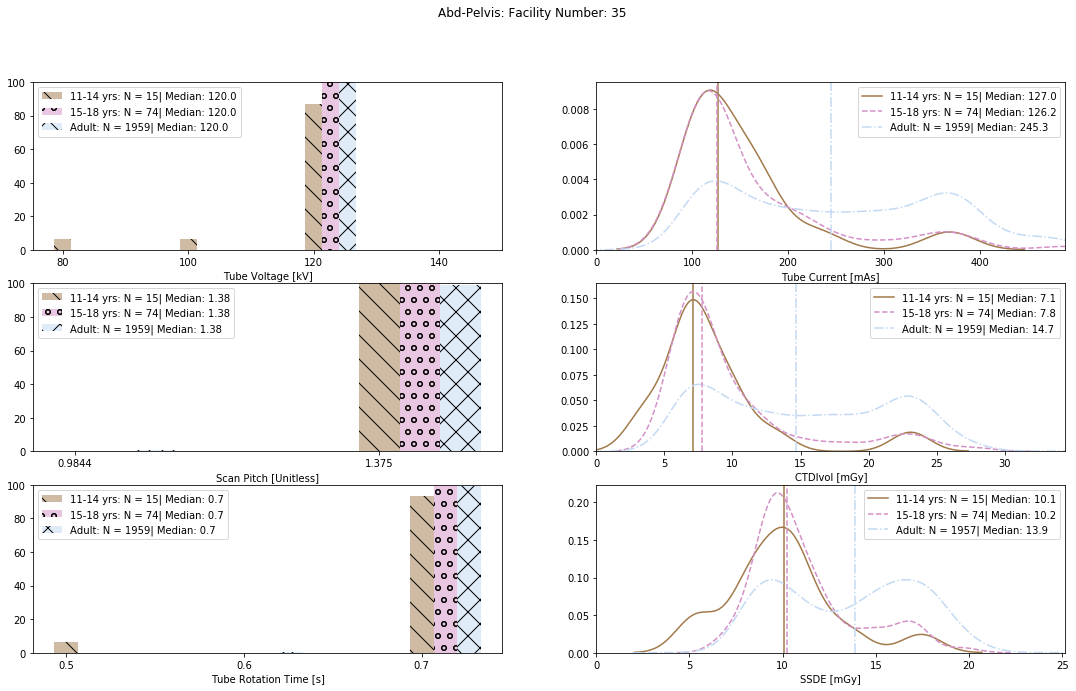


------ 
Location:  40

------ 
Location:  41

------ 
Location:  44


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationW

Adult and 15-18 yrs  | Different Distributions? (KVP): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (mA): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Pitch): False
Adult and 15-18 yrs  | Different Distributions? (RevTime): False
Adult and 15-18 yrs  | Different Distributions? (CTDI): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (SSDE): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Size): True| Ped is lower: True



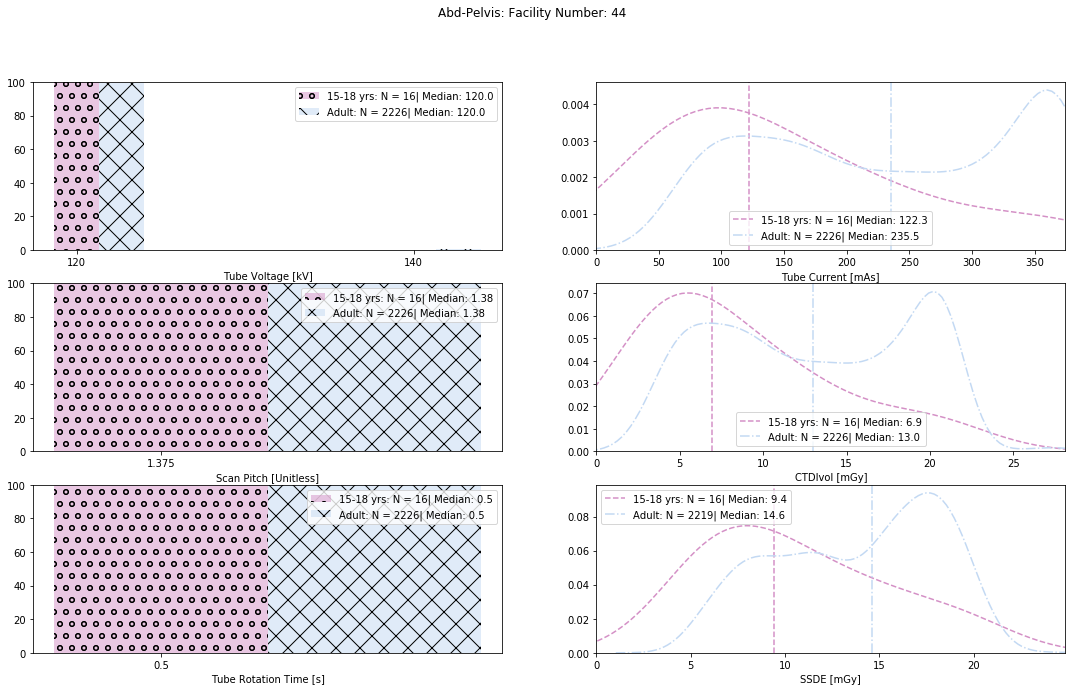


------ 
Location:  46

------ 
Location:  47

------ 
Location:  48

------ 
Location:  51

------ 
Location:  52

------ 
Location:  54

------ 
Location:  64


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationW

Adult and 15-18 yrs  | Different Distributions? (KVP): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (mA): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Pitch): False
Adult and 15-18 yrs  | Different Distributions? (RevTime): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (CTDI): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (SSDE): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Size): True| Ped is lower: True



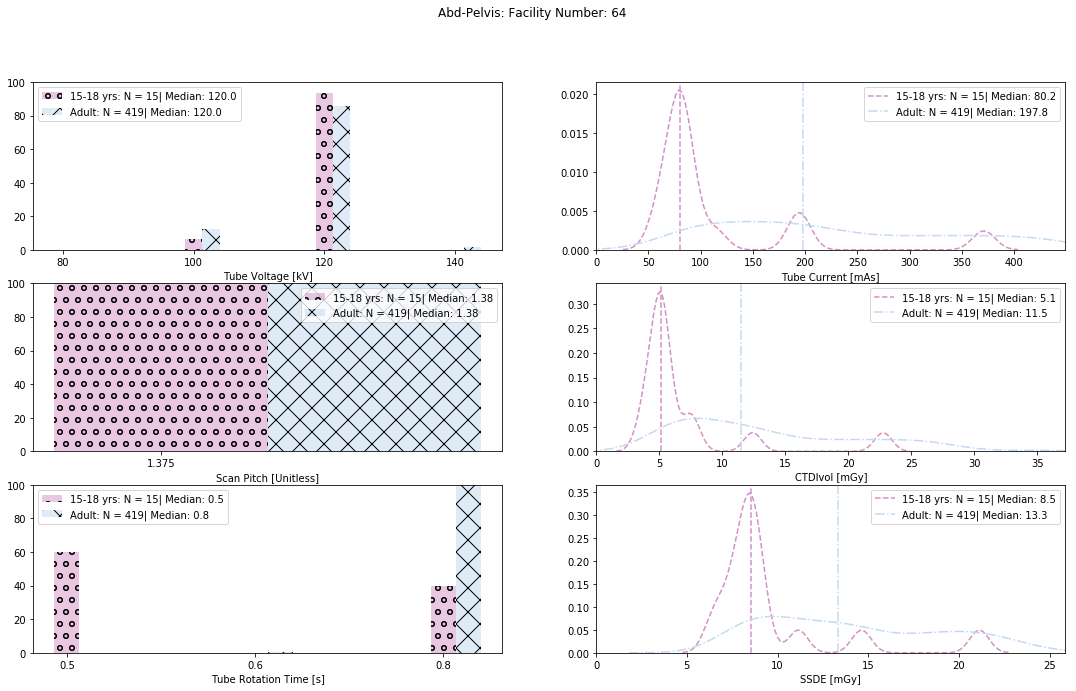


------ 
Location:  70

------ 
Location:  72

------ 
Location:  73

------ 
Location:  74

------ 
Location:  75


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationW

Adult and 15-18 yrs  | Different Distributions? (KVP): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (mA): False| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Pitch): False
Adult and 15-18 yrs  | Different Distributions? (RevTime): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (CTDI): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (SSDE): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Size): True| Ped is lower: True



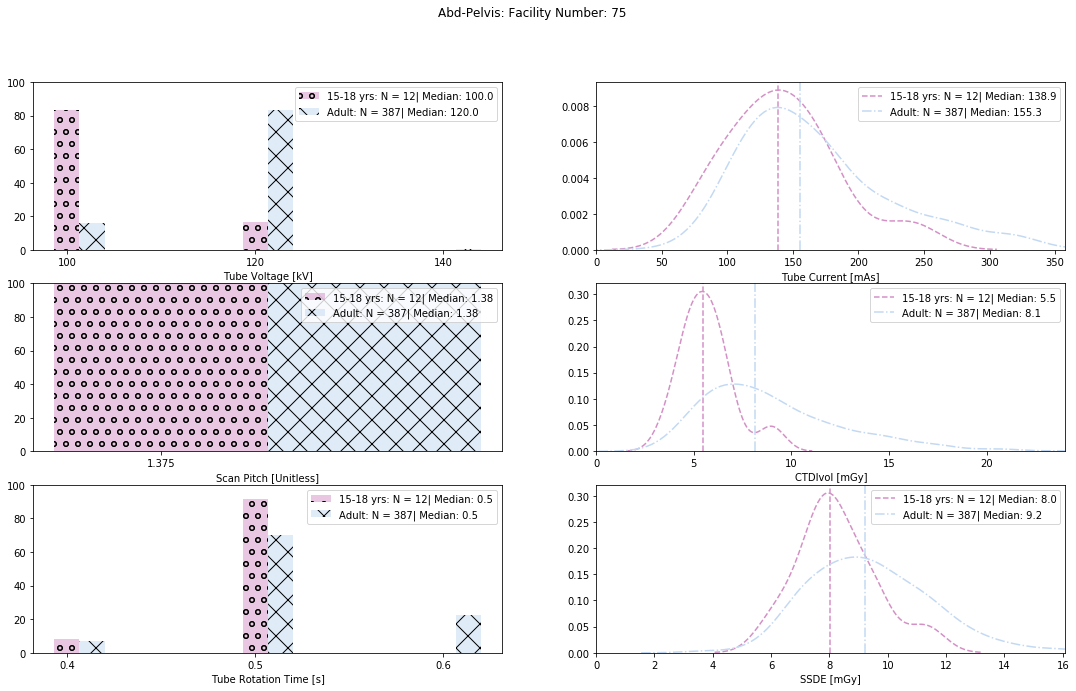


------ 
Location:  76

------ 
Location:  77

------ 
Location:  78

------ 
Location:  81


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationW

Adult and 11-14 yrs  | Different Distributions? (KVP): False| Ped is lower: False
Adult and 11-14 yrs  | Different Distributions? (mA): True| Ped is lower: True
Adult and 11-14 yrs  | Different Distributions? (Pitch): True| Ped is lower: False
Adult and 11-14 yrs  | Different Distributions? (RevTime): True| Ped is lower: True
Adult and 11-14 yrs  | Different Distributions? (CTDI): True| Ped is lower: True
Adult and 11-14 yrs  | Different Distributions? (SSDE): True| Ped is lower: True
Adult and 11-14 yrs  | Different Distributions? (Size): True| Ped is lower: True

Adult and 15-18 yrs  | Different Distributions? (KVP): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (mA): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Pitch): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (RevTime): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (CTDI): True| Ped is lower: True
Adult and 15-18 

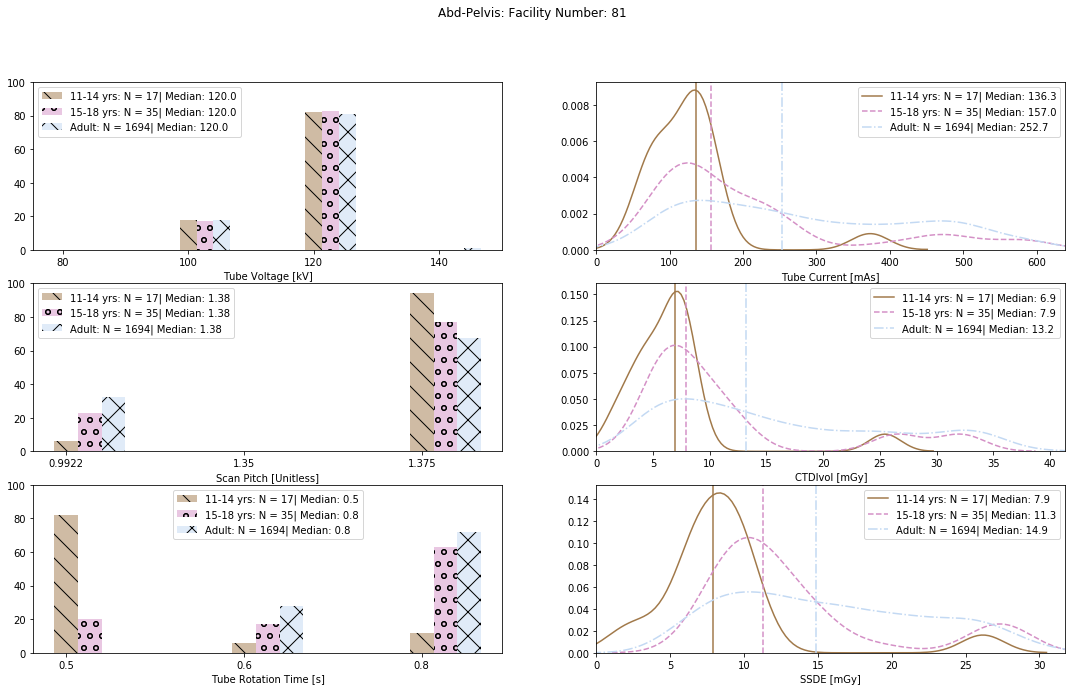


------ 
Location:  82

------ 
Location:  89

------ 
Location:  90

------ 
Location:  91

------ 
Location:  95


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationW

Adult and 15-18 yrs  | Different Distributions? (KVP): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (mA): False| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Pitch): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (RevTime): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (CTDI): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (SSDE): False| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Size): True| Ped is lower: True



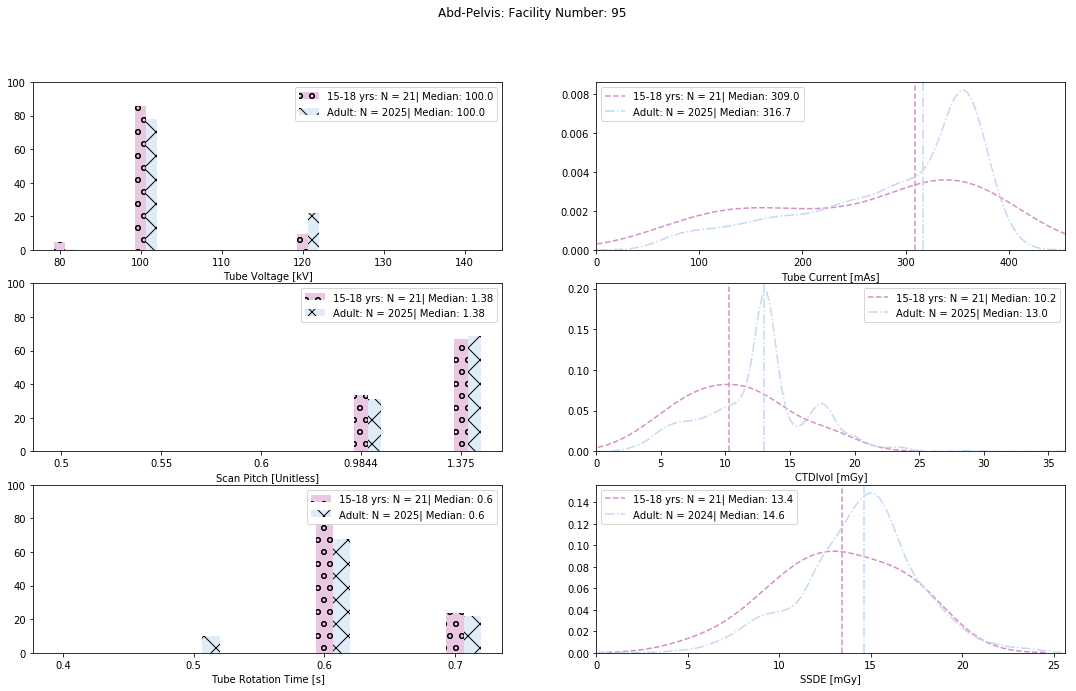


------ 
Location:  97

------ 
Location:  98

------ 
Location:  101

------ 
Location:  105

------ 
Location:  109


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationW

Adult and 15-18 yrs  | Different Distributions? (KVP): False
Adult and 15-18 yrs  | Different Distributions? (mA): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Pitch): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (RevTime): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (CTDI): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (SSDE): False| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Size): True| Ped is lower: True



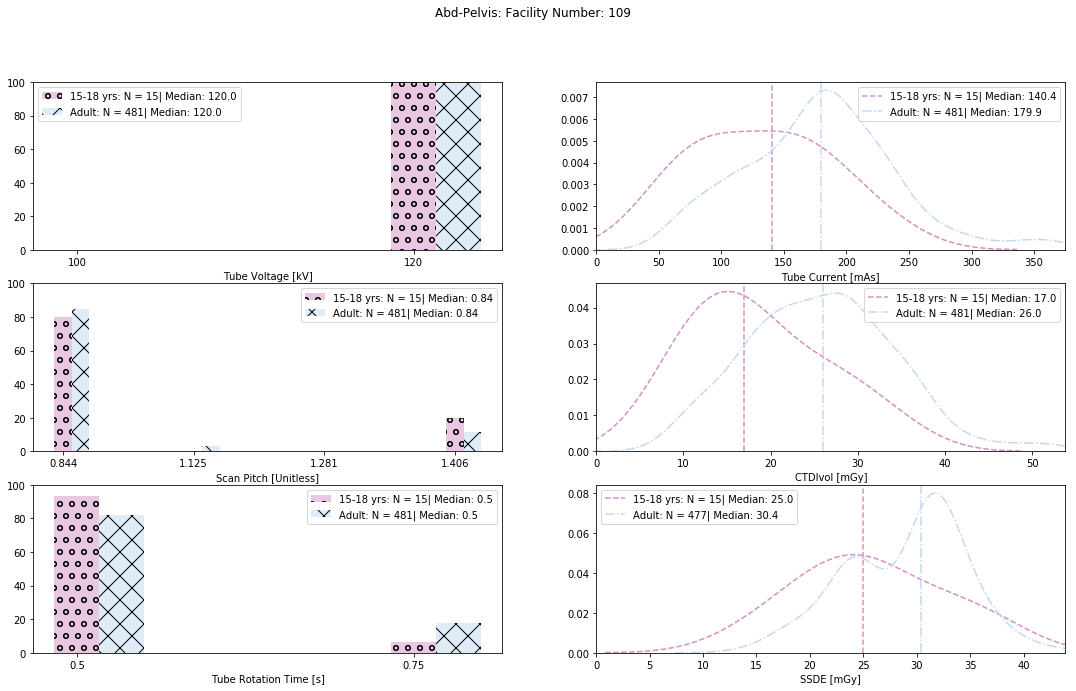


------ 
Location:  128

------ 
Location:  129

------ 
Location:  130

------ 
Location:  131

------ 
Location:  132

------ 
Location:  134


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationW

Adult and 15-18 yrs  | Different Distributions? (KVP): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (mA): False| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Pitch): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (RevTime): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (CTDI): False| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (SSDE): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (Size): False| Ped is lower: True



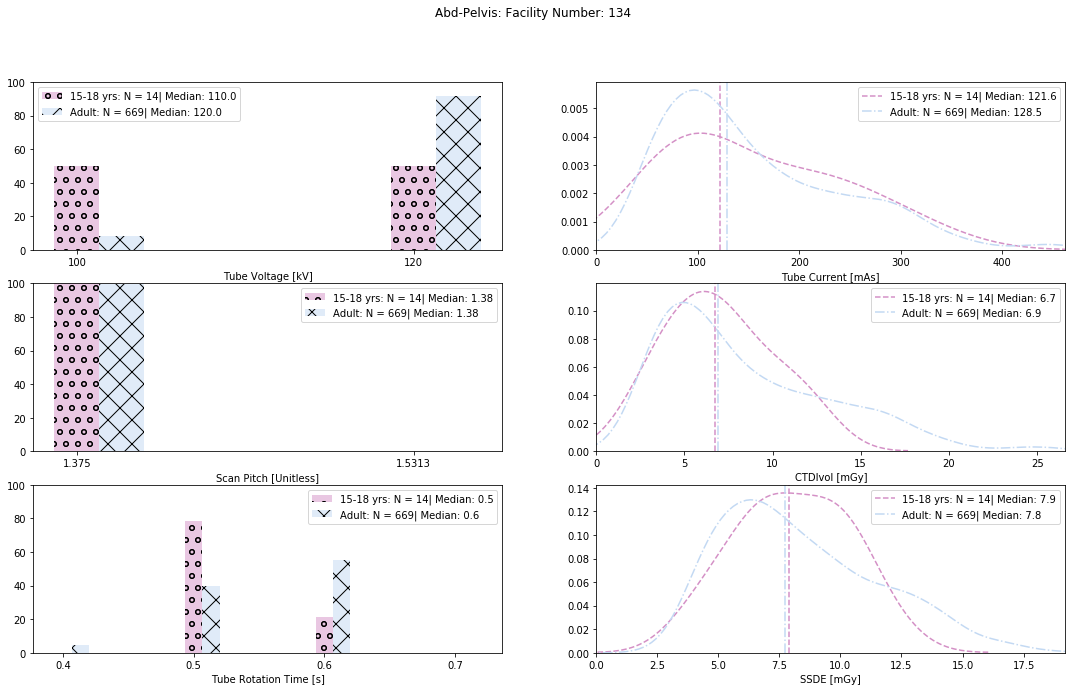


------ 
Location:  136

------ 
Location:  138

------ 
Location:  139

------ 
Location:  141

------ 
Location:  142

------ 
Location:  143

------ 
Location:  144

------ 
Location:  147

------ 
Location:  150

------ 
Location:  151

------ 
Location:  152


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationW

Adult and 15-18 yrs  | Different Distributions? (KVP): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (mA): False| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Pitch): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (RevTime): True| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (CTDI): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (SSDE): False| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Size): True| Ped is lower: True



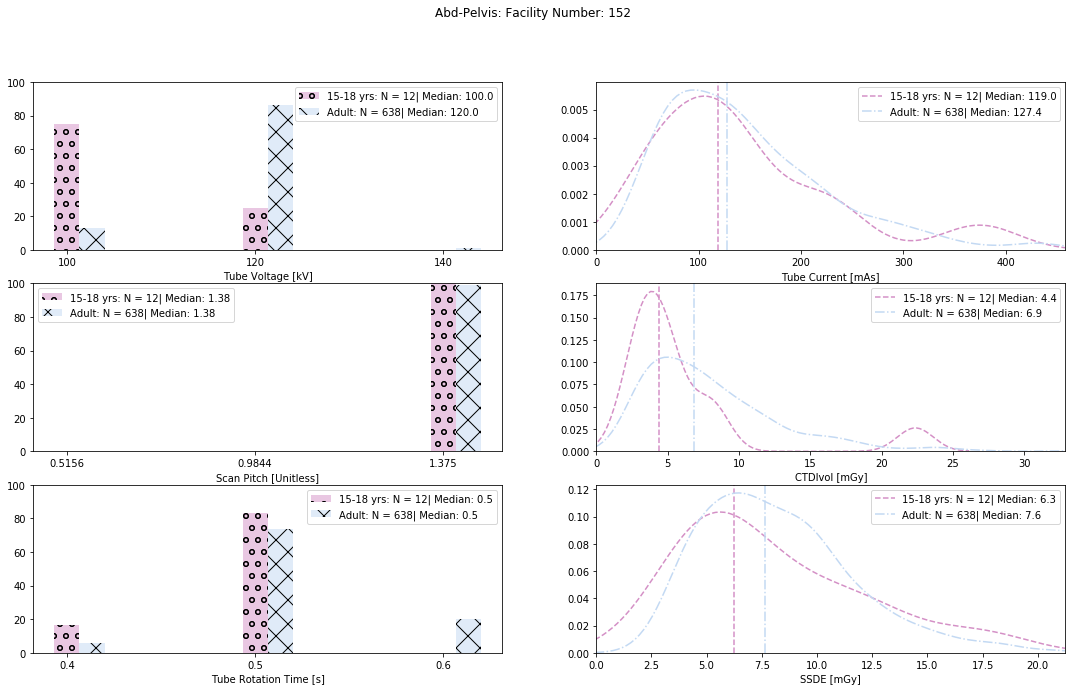


------ 
Location:  154

------ 
Location:  160

------ 
Location:  161


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationW

Adult and 15-18 yrs  | Different Distributions? (KVP): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (mA): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Pitch): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (RevTime): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (CTDI): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (SSDE): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Size): True| Ped is lower: True



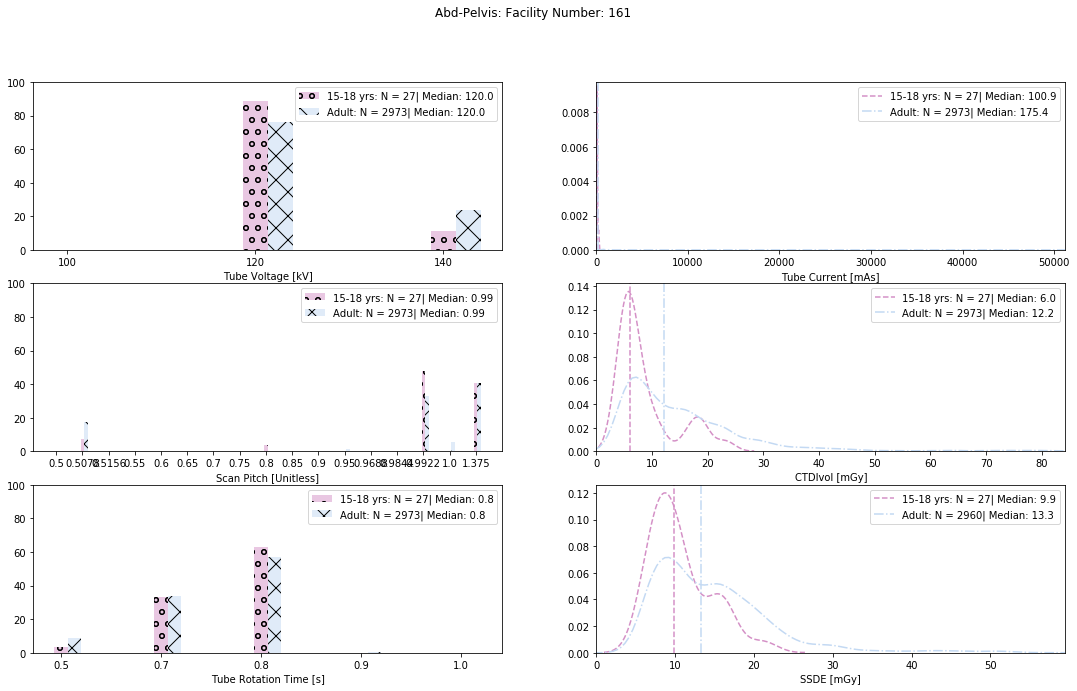


------ 
Location:  166

------ 
Location:  167

------ 
Location:  168

------ 
Location:  169

------ 
Location:  170

------ 
Location:  172

------ 
Location:  173


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationW

Adult and 15-18 yrs  | Different Distributions? (KVP): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (mA): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Pitch): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (RevTime): False
Adult and 15-18 yrs  | Different Distributions? (CTDI): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (SSDE): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Size): True| Ped is lower: True



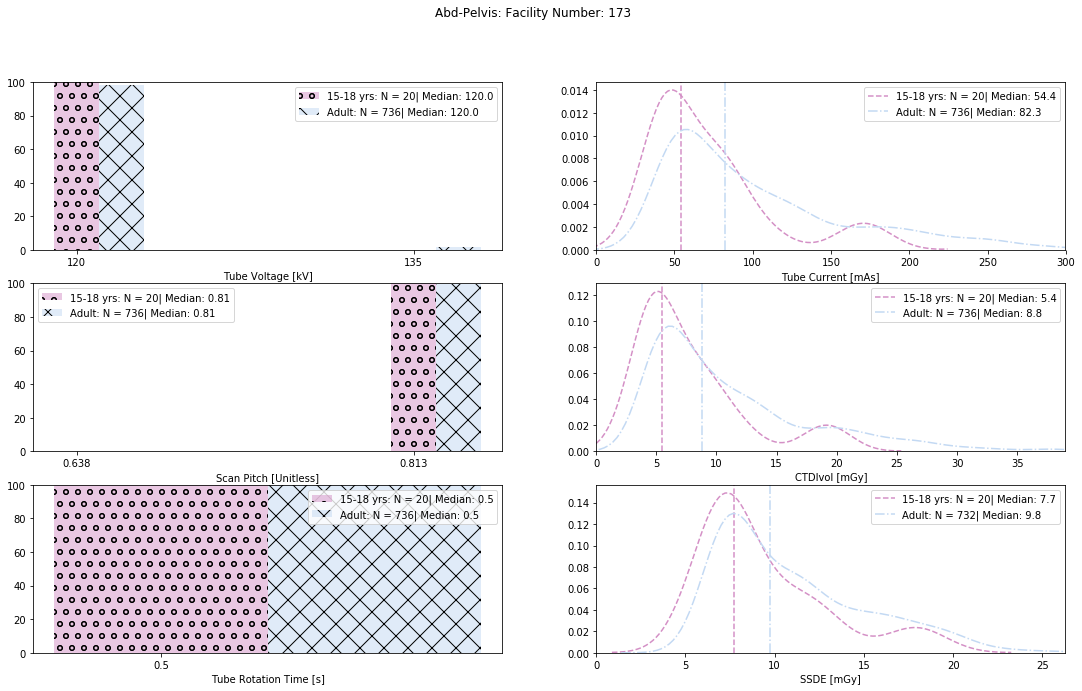


------ 
Location:  175

------ 
Location:  178

------ 
Location:  179


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationW

Adult and 15-18 yrs  | Different Distributions? (KVP): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (mA): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Pitch): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (RevTime): False| Ped is lower: False
Adult and 15-18 yrs  | Different Distributions? (CTDI): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (SSDE): True| Ped is lower: True
Adult and 15-18 yrs  | Different Distributions? (Size): True| Ped is lower: True



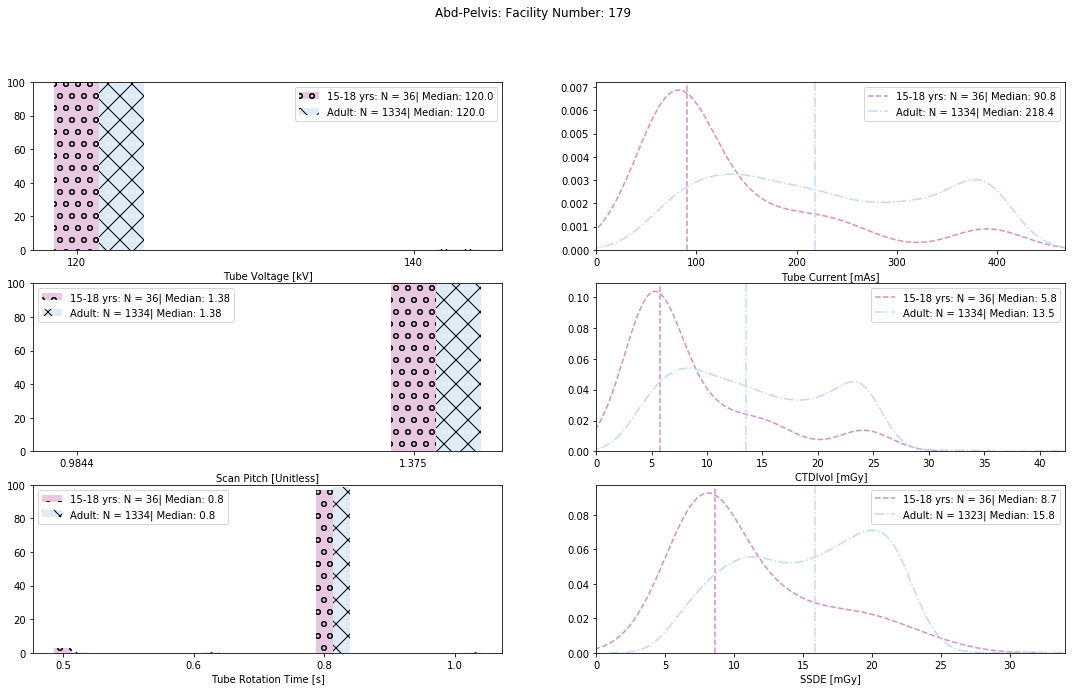


------ 
Location:  180

------ 
Location:  182

------ 
Location:  183

------ 
Location:  184

------ 
Location:  186

------ 
Location:  187

------ 
Location:  189

------ 
Location:  195


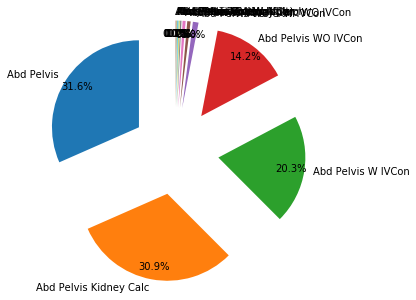

Abd Pelvis                         5907
Abd Pelvis Kidney Calc             5774
Abd Pelvis W IVCon                 3788
Abd Pelvis WO IVCon                2661
Abd Pelvis WO & W IVCon             196
Abd Pelvis Uro                      116
Abd Pelvis Kidney Calc WO IVCon     106
Abd Pelvis Entero                    45
Abd Pelvis Appx                      29
Abd Pelvis Uro W IVCon               27
Peds Abd Pelvis                      13
Abd Pelvis Entero Multiph            12
Abd Pelvis Uro Multiph               10
Abd Pelvis Colongrphy                 8
Abd Pelvis Multiph Liver              3
Name: z2_acquisition_protocol, dtype: int64
['Abd Pelvis', 'Abd Pelvis Kidney Calc', 'Abd Pelvis W IVCon', 'Abd Pelvis WO IVCon', 'Abd Pelvis WO & W IVCon', 'Abd Pelvis Uro', 'Abd Pelvis Kidney Calc WO IVCon', 'Abd Pelvis Entero', 'Abd Pelvis Appx', 'Abd Pelvis Uro W IVCon', 'Peds Abd Pelvis', 'Abd Pelvis Entero Multiph', 'Abd Pelvis Uro Multiph', 'Abd Pelvis Colongrphy', 'Abd Pelvis Multiph Liver

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)


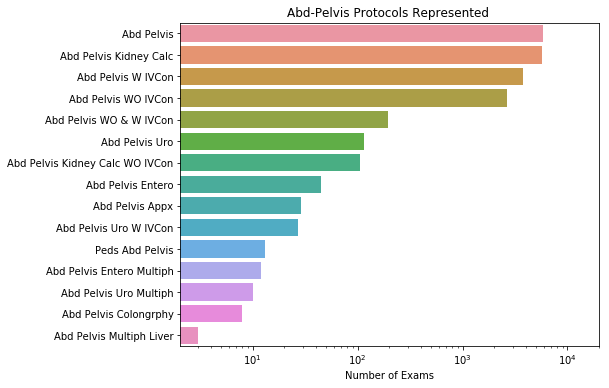

NameError: name 'file' is not defined

In [6]:
import math

from scipy.special import logit, expit
from scipy import stats

import matplotlib

# Subplot dimensions
m = 2
n = 3
fullDataList = []

# Plotting choices
al = 0.5
sp = 15

patterns = ('-','*', '', '+', '\\', 'o', 'x', 'O', '.')
ls = ('-', '--', '-.', ':','-','--','-.',':',)

cmap = matplotlib.cm.get_cmap('gist_rainbow') # Rainbow
cmap = matplotlib.cm.get_cmap('cubehelix') # Good for black and white

# Set how many plots to actually show (can lower to just check if it runs right)
nPlotsToShow = 999

# Get rid of the infs in the dataset by setting them to nans
truealldata_df = truealldata_df.replace([np.inf, -np.inf], np.nan)


# Get all locations which have patients at them and make a subplot according to this number of cases
allLocations = truealldata_df['LOC'][(truealldata_df['z2_acquisition_protocol_type']==protoType)]
locations = set(allLocations)
ss = math.ceil(math.sqrt(len(locations)))

allAgeGroups = truealldata_df['z2_patient_age_group'][ (truealldata_df['z2_acquisition_protocol_type']==protoType)]
agegroups = set(allAgeGroups)
ages = ('N/A','0-2 yrs','3-6 yrs','7-10 yrs','11-14 yrs','15-18 yrs','Adult')

if(writeToFile):
    file = open('Comparisons_'+protoType+'.txt','w') 
    file.write(protoType+'\n')
    from datetime import date
    today = str(date.today())
    file.write(today+'\n')


fulllistprots = []

cnt = 1
for i in locations:
    plt.figure()
    # Get this locations data
    wasthereany = False
    cntany = 0
    
    thisord = []
    allkvps = []
    allma = []
    allctdivol = []
    allssdes = []
    allrevtimes = []
    allsizes = []
    allpitch = []
    allnoise = []
    allres = []
    allprots = []
    thisgroup=[]
    
    orderlegs = []
#    for j in agegroups:
    
    
    allages_thisloc_data = (truealldata_df.loc[(truealldata_df['LOC']==i )& (truealldata_df['z2_acquisition_protocol_type']==protoType) ,:])

    kvp_ticks = np.sort(np.asarray(list(set(allages_thisloc_data['KVP']))));
    pitch_ticks = np.sort(np.asarray(list(set(allages_thisloc_data['z2_min_pitch']))));
    revtime_ticks = np.sort(np.asarray(list(set(allages_thisloc_data['z2_max_revolution_time']))));
    
    mas_all = np.asarray(allages_thisloc_data['z2_avg_mas'])
    ctdi_all = np.asarray(allages_thisloc_data['Z2_ctdivol'])
    ssde_all = np.asarray(allages_thisloc_data['z2_ssde_ctdivol'])
    
    print('')
    print('------ ')
    print('Location: ',str(i))
    
    if(writeToFile):
        file.write('\n')
        file.write('------ ')
        file.write('Location: '+str(i)+'\n')

    for j in np.arange(1,7):
        thisdata = (truealldata_df.loc[(truealldata_df['LOC']==i )& (truealldata_df['z2_acquisition_protocol_type']==protoType) & (truealldata_df['z2_patient_age_group']==j) ,:])
        thisdata = (truealldata_df.loc[(truealldata_df['LOC']==i )& (truealldata_df['z2_acquisition_protocol_type']==protoType) & (truealldata_df['Z2_patient_age_group_order']==j) ,:])
        
        if(whichPhase==-1): # If we don't restrict an acquisition then use all of them
            thisdata = (truealldata_df.loc[(truealldata_df['LOC']==i )& (truealldata_df['z2_acquisition_protocol_type']==protoType) & (truealldata_df['Z2_patient_age_group_order']==j)  ,:])
        else:
            thisdata = (truealldata_df.loc[(truealldata_df['LOC']==i )& (truealldata_df['z2_acquisition_protocol_type']==protoType) & (truealldata_df['Z2_patient_age_group_order']==j)&(truealldata_df['scan_number'] == whichPhase)  ,:])
        
        # Now make sure that there is only one StudyUId per scan (so we don't duplicate Studies)
        
        
        
        # Make lists of this agegroup-location combination
        thesema = ((thisdata['z2_max_xray_tube_current'])).dropna(); # Can also choose to use just mA
        thesema = ((thisdata['z2_avg_mas'])).dropna();
        thesekvps = ((thisdata['KVP'])).dropna();
        theserevtimes = ((thisdata['z2_max_revolution_time'])).dropna();
        theseages = ((thisdata['Z2_patient_age_group_order'])).dropna();
        thesectdivol = ((thisdata['Z2_ctdivol'])).dropna();
        thesessdes = ((thisdata['z2_ssde_ctdivol'])).dropna();
        thesesizes = ((thisdata['z2_effective_diameter'])).dropna();
        thesepitch = ((thisdata['z2_min_pitch'])).dropna();
        thesenoise = ((thisdata['z1_noisebody9_Aggregate'])).dropna();
        theseres = ((thisdata['RES'])).dropna();
        theseprots = ((thisdata['z2_acquisition_protocol'])).dropna();
        
        # Have to scale these before you drop the NaNs
        sf = 1/(1.99)
        
        tmpthesectdivol = []
        tmpthesessdes = []
        thesectdivol = []
        tmpthesessdes = []
        
        tmpthesectdivol = ((thisdata['Z2_ctdivol']));
        tmpthesessdes = ((thisdata['z2_ssde_ctdivol']));
        tmpthesephantoms = ((thisdata['phantom']));
        
        # scale the SSDE and CTDIVol appropriately
        phantoms_peds = tmpthesephantoms=='Head 16'
        phantoms_null = tmpthesephantoms=='NULL'
        
        tmpthesectdivol[phantoms_peds] = sf*tmpthesectdivol[phantoms_peds]
        tmpthesessdes[phantoms_peds] = sf*tmpthesessdes[phantoms_peds]
        tmpthesectdivol[phantoms_null] = np.nan
        tmpthesessdes[phantoms_null] = np.nan
        
        
        thesectdivol = tmpthesectdivol.dropna()
        thesessdes = tmpthesessdes.dropna()
        thesephantoms = tmpthesephantoms.dropna()
        
        
        
        # Only plot if there are enough points
        if((min(len(thesema),len(thesekvps),len(theserevtimes),len(theseages),len(thesectdivol),len(thesessdes),len(thesepitch) )>minNumDataPoints)):
        #if(len(thisdata)>minNumDataPoints):
            wasthereany=True
            cntany = cntany+1            
            
            whichnum = np.median(theseages) # Get the age grouporder
            
            # make larger list of all ages at this locations
            allkvps.append(thesekvps)
            allrevtimes.append(theserevtimes)
            allma.append(thesema)
            allctdivol.append(thesectdivol)
            allssdes.append(thesessdes)
            allsizes.append(thesesizes)
            allpitch.append(thesepitch)
            allnoise.append(thesenoise)
            allres.append(theseres)
            allprots.append(theseprots)
            
            # Choose bin widths (outdated now that we use KDEs)
            bw_kvp = np.arange(60,160,5)
            bw_ma = np.arange(0,800,20)
            bw_pitch = np.arange(0,3,0.25)
            bw_ctdi = np.arange(0,50,3)
            bw_noise = np.arange(0,200,5)
            bw_res = np.arange(0,2,0.1)

            orderlegs.append(whichnum)
            
            
            #### Make the plots for the analysis
            
            ## KVP plot
            ax1= plt.subplot(n,m,1)
            kvp_barWidth= 2
            nKv = 0
            kvs = set(thesekvps)
            sm = 0
            for l in np.arange(0,len(kvp_ticks)):
                tmp = (kvp_ticks[l])
                nKv = sum(thesekvps==tmp)
                sm = sm +nKv

            kvpcnt = 0
            for l in np.arange(0,len(kvp_ticks)):
                tmp = (kvp_ticks[l])
                nKv = sum(thesekvps==tmp)

                intnum=int(whichnum)
                if(kvpcnt==0):
                    ax1=    plt.bar((l*sp)+kvp_barWidth*(cntany-1), 100*nKv/sm,
                                label =ages[j]+': N = '+str(len(thesekvps))+'| Median: '+str(round(np.percentile(thesekvps, percentilReported),-1)),
                                color=cmap(((whichnum-1)/6)),width=kvp_barWidth,hatch=patterns[intnum],alpha = al)
                else:
                    ax1=    plt.bar((l*sp)+kvp_barWidth*(cntany-1), 100*nKv/sm,
                                color=cmap(((whichnum-1)/6)),width=kvp_barWidth,hatch=patterns[intnum],alpha = al)
                kvpcnt = kvpcnt+1
            plt.legend()
            
            plt.xticks(sp*np.arange(0,len(kvp_ticks)),kvp_ticks)
            plt.ylim(0,100)
            plt.xlabel('Tube Voltage [kV]')
            ###---------###
            
            ## mAs plot
            plt.subplot(n,m,2)
            ax2 = sns.distplot(thesema,
                              label =ages[j]+': N = '+str(len(thesema))+'| Median: '+str(round(np.percentile(thesema, percentilReported),1)) ,
                              kde=True,norm_hist=True,rug=False,hist=False,kde_kws={'linestyle':ls[intnum],'clip': (0, 999999)},
                              color=cmap(((whichnum-1)/6)),bins = bw_ma)
            ax2.axvline(x=np.percentile(thesema, percentilReported),color=cmap(((whichnum-1)/6)),linestyle=ls[intnum])
            plt.xlim(0,np.nanmax(mas_all))
            plt.xlabel('Tube Current [mAs]')

            ###---------###

            
            ## Pitch plot
            ax3 = plt.subplot(n,m,3)
            '''
            ax3 = sns.distplot(thesepitch,
                              label =ages[j]+': N = '+str(len(thisdata))+'| Median: '+str(round(np.percentile(thesepitch, 100-percentilReported),2)) ,
                              kde=False,norm_hist=True,rug=False,
                              color=cmap(((whichnum-1)/6)),bins = bw_pitch)
            ax3.axvline(x=np.percentile(thesepitch, 100-percentilReported),color=cmap(((whichnum-1)/6)),linestyle=ls[intnum])
            '''
            pitch_barWidth = 2
            nPitch = 0
            
            pitch = set(thesepitch)
            sm = 0
            for l in np.arange(0,len(pitch_ticks)):
                tmp = (pitch_ticks[l])
                nPitch = sum(thesepitch==tmp)

                sm = sm +nPitch

            pitchcnt = 0
            for l in np.arange(0,len(pitch_ticks)):
                tmp = (pitch_ticks[l])
                nPitch = sum(thesepitch==tmp)

                intnum=int(whichnum)
                
                if(pitchcnt==0):
                    ax1=    plt.bar((l*sp)+pitch_barWidth*(cntany-1), 100*nPitch/sm,
                                    label =ages[j]+': N = '+str(len(thesepitch))+'| Median: '+str(round(np.percentile(thesepitch, 100-percentilReported),2)) ,
                                    color=cmap(((whichnum-1)/6)),width=pitch_barWidth,hatch=patterns[intnum],alpha = al)
                else:
                    ax1=    plt.bar((l*sp)+pitch_barWidth*(cntany-1), 100*nPitch/sm,color=cmap(((whichnum-1)/6)),width=pitch_barWidth,hatch=patterns[intnum],alpha = al)
                    
                pitchcnt = pitchcnt+1
            plt.legend()
            plt.xticks(sp*np.arange(0,len(pitch_ticks)),pitch_ticks)
            plt.ylim(0,100)
            plt.xlabel('Scan Pitch [Unitless]')
            ###---------###

            
            ## CTDIVol plot
            plt.subplot(n,m,4)
            ax4 = sns.distplot(thesectdivol,
                              label =ages[j]+': N = '+str(len(thesectdivol))+'| Median: '+str(round(np.percentile(thesectdivol, percentilReported),1)) ,
                              kde=True,norm_hist=True,rug=False,hist=False,kde_kws={'linestyle':ls[intnum],'clip': (0, 999999) },
                              color=cmap(((whichnum-1)/6)),bins = bw_ctdi)
            ax4.axvline(x=np.percentile(thesectdivol, percentilReported),color=cmap(((whichnum-1)/6)),linestyle=ls[intnum])
            plt.xlim(0,np.nanmax(ctdi_all))
            plt.xlabel('CTDIvol [mGy]')

            ###---------###

            
            ## Revolution Time plot
            ax5= plt.subplot(n,m,5)
            revtime_barWidth= 2
            nRevTime = 0
            revtimes = set(theserevtimes)
            sm = 0
            for l in np.arange(0,len(revtime_ticks)):
                tmp = (revtime_ticks[l])
                nRevTime = sum(theserevtimes==tmp)
                sm = sm +nRevTime

            revtimecnt = 0
            for l in np.arange(0,len(revtime_ticks)):
                tmp = (revtime_ticks[l])
                nRevTime = sum(theserevtimes==tmp)

                intnum=int(whichnum)
                if(revtimecnt==0):
                    ax5=    plt.bar((l*sp)+revtime_barWidth*(cntany-1), 100*nRevTime/sm,
                                    label =ages[j]+': N = '+str(len(theserevtimes))+'| Median: '+str(round(np.percentile(theserevtimes, percentilReported),1)) ,
                                    color=cmap(((whichnum-1)/6)),width=revtime_barWidth,hatch=patterns[intnum],alpha = al)
                else:
                    ax5=    plt.bar((l*sp)+revtime_barWidth*(cntany-1), 100*nRevTime/sm,color=cmap(((whichnum-1)/6)),width=revtime_barWidth,hatch=patterns[intnum],alpha = al)
                revtimecnt = revtimecnt+1
            plt.legend()
            
            plt.xticks(sp*np.arange(0,len(revtime_ticks)),revtime_ticks)
            plt.ylim(0,100)
            plt.xlabel('Tube Rotation Time [s]')
            ###---------###

            
            ## SSDE plot
            plt.subplot(n,m,6)
            ax6 = sns.distplot(thesessdes,
                              label =ages[j]+': N = '+str(len(thesessdes))+'| Median: '+str(round(np.percentile(thesessdes, percentilReported),1)) ,
                              kde=True,norm_hist=True,rug=False,hist=False,kde_kws={'linestyle':ls[intnum],'clip': (0, 999999) },
                              color=cmap(((whichnum-1)/6)),bins = bw_ctdi)
            ax6.axvline(x=np.percentile(thesessdes, percentilReported),color=cmap(((whichnum-1)/6)),linestyle=ls[intnum])
            plt.xlim(0,np.nanmax(ssde_all))
            plt.xlabel('SSDE [mGy]')

            ###---------###

            
            if(showIQ):
                plt.subplot(n,m,7)
                ax5 = sns.distplot(thesenoise,
                              label =ages[j]+': N = '+str(len(thesenoise))+'| Median: '+str(round(np.percentile(thesenoise, percentilReported),1)) ,
                              kde=True,norm_hist=True,rug=False,hist=False,kde_kws={'linestyle':ls[intnum],'clip': (0, 999999)},
                              color=cmap(((whichnum-1)/6)),bins = bw_noise)
                ax5.axvline(x=np.percentile(thesenoise, percentilReported),color=cmap(((whichnum-1)/6)),linestyle=ls[intnum])

                plt.subplot(n,m,8)
                ax6 = sns.distplot(theseres,
                              label =ages[j]+': N = '+str(len(theseres))+'| Median: '+str(round(np.percentile(theseres, percentilReported),2)) ,
                              kde=True,norm_hist=True,rug=False,hist=False,kde_kws={'linestyle':ls[intnum],'clip': (0, 999999)},
                              color=cmap(((whichnum-1)/6)),bins = bw_res)
                ax6.axvline(x=np.percentile(theseres, percentilReported),color=cmap(((whichnum-1)/6)),linestyle=ls[intnum])
    
            
            thisord.append(int(whichnum))
            thisgroup.append(ages[j])
            ####
            
            fig = matplotlib.pyplot.gcf()
            fig.set_size_inches(18.5, 10.5)
            
        plt.suptitle(protoType+': Facility Number: '+str(i))
        
    ##### Now, if there was enough age groups, then do the Kruskall-Wallis test of significant difference    
    if((wasthereany)&(cntany>1)):
        cnt=cnt+1
        
        

        
        # Reorder the legend if it isn't already ordered (deprecated)
        '''
        ax1.legend()  
        handles,labels = ax1.get_legend_handles_labels()
        idxords = np.argsort(orderlegs)
        ax1.legend([handles[idx] for idx in idxords],[labels[idx] for idx in idxords])
        
        
        ax2.legend()  
        handles,labels = ax2.get_legend_handles_labels()
        idxords = np.argsort(orderlegs)
        ax2.legend([handles[idx] for idx in idxords],[labels[idx] for idx in idxords])

        ax3.legend()  
        handles,labels = ax3.get_legend_handles_labels()
        idxords = np.argsort(orderlegs)
        ax3.legend([handles[idx] for idx in idxords],[labels[idx] for idx in idxords])
        
        
        ax4.legend()  
        handles,labels = ax4.get_legend_handles_labels()
        idxords = np.argsort(orderlegs)
        ax4.legend([handles[idx] for idx in idxords],[labels[idx] for idx in idxords])

        
        if(showIQ):
            ax5.legend()  
            handles,labels = ax5.get_legend_handles_labels()
            idxords = np.argsort(orderlegs)
            ax5.legend([handles[idx] for idx in idxords],[labels[idx] for idx in idxords])

        
            ax6.legend()  
            handles,labels = ax6.get_legend_handles_labels()
            idxords = np.argsort(orderlegs)
            ax6.legend([handles[idx] for idx in idxords],[labels[idx] for idx in idxords])
        
        '''
            
        whichindisAdult = thisord.index(6)
        krsk_kvp = []
        krsk_ma = []
        krsk_ctdi = []
        krsk_size = []
        krsk_pitch = []
        krsk_noise = []
        krsk_res = []
        
    
    
        # Print the values of the categorical variables
        #print('kV Values: ',str(kvp_ticks))
        #print('pitch Values: ',str(pitch_ticks))
        #print('Revoution Time Values: ',str(revtime_ticks))
        #print('')
        
        # Print the results of the kruskall wallis
        for k in np.arange(0,len(allkvps)):
            fullDataList.append(allprots[k])
            #print(len(fullDataList))
            if (not(whichindisAdult ==k)  ):
                ### KVP
                if((len(set(allkvps[whichindisAdult])) == 1) and(len(set(allkvps[whichindisAdult])) == 1)):
                    print(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (KVP): '+'False')
                    if(writeToFile):
                        file.write((thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (KVP): '+'False'+'\n'))



                else:
                    krsk_kvp = stats.kruskal(allkvps[whichindisAdult], allkvps[k])
                    islower_kvp = np.percentile(allkvps[whichindisAdult], percentilReported) > np.percentile(allkvps[k], percentilReported)
                    print(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (KVP): '+str(krsk_kvp.pvalue < 0.05)+'| Ped is lower: '+str(bool(islower_kvp)))
                    if(writeToFile):
                        file.write((thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (KVP): '+str(krsk_kvp.pvalue < 0.05)+'| Ped is lower: '+str(bool(islower_kvp))+'\n'))
                ###---------###

                
                
                    
                ### mA
                if((len(set(allma[whichindisAdult])) == 1) and(len(set(allma[whichindisAdult])) == 1)):
                    print(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (mA): '+'False')
                    if(writeToFile):
                        file.write(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (mA): '+'False'+'\n')
                else:
                    krsk_ma = stats.kruskal(allma[whichindisAdult], allma[k])
                    islower_ma = np.percentile(allma[whichindisAdult],percentilReported) > np.percentile(allma[k],percentilReported)
                    print(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (mA): '+str(krsk_ma.pvalue < 0.05)+'| Ped is lower: '+str(bool(islower_ma)))
                    if(writeToFile):
                        file.write(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (mA): '+str(krsk_ma.pvalue < 0.05)+'| Ped is lower: '+str(bool(islower_ma))+'\n')
                        
                ###---------###

                  
                    
                    
                ### PITCH
                if((len(set(allpitch[whichindisAdult])) == 1) and(len(set(allpitch[whichindisAdult])) == 1)):
                    print(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (Pitch): '+'False')
                    if(writeToFile):
                        file.write(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (Pitch): '+'False'+'\n')
                else:
                    krsk_pitch = stats.kruskal(allpitch[whichindisAdult], allpitch[k])
                    islower_pitch = np.percentile(allpitch[whichindisAdult],100-percentilReported) > np.percentile(allpitch[k],100-percentilReported)
                    print(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (Pitch): '+str(krsk_pitch.pvalue < 0.05)+'| Ped is lower: '+str(bool(islower_pitch)))
                    if(writeToFile):
                        file.write(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (Pitch): '+str(krsk_pitch.pvalue < 0.05)+'| Ped is lower: '+str(bool(islower_pitch))+'\n')
                ###---------###
    
    
    
                ### Revolution Time
                if((len(set(allrevtimes[whichindisAdult])) == 1) and(len(set(allrevtimes[whichindisAdult])) == 1)):
                    print(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (RevTime): '+'False')
                    if(writeToFile):
                        file.write(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (RevTime): '+'False')


                else:
                    krsk_revtime = stats.kruskal(allrevtimes[whichindisAdult], allrevtimes[k])
                    islower_revtime = np.percentile(allrevtimes[whichindisAdult], percentilReported) > np.percentile(allrevtimes[k], percentilReported)
                    print(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (RevTime): '+str(krsk_revtime.pvalue < 0.05)+'| Ped is lower: '+str(bool(islower_revtime)))
                    if(writeToFile):
                        file.write(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (RevTime): '+str(krsk_revtime.pvalue < 0.05)+'| Ped is lower: '+str(bool(islower_revtime))+'\n')
                ###---------###
    
                    
                ### CTDI
                if((len(set(allctdivol[whichindisAdult])) == 1) and(len(set(allctdivol[whichindisAdult])) == 1)):
                    print(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (CTDI): '+'False')
                    if(writeToFile):
                        file.write(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (CTDI): '+'False'+'\n')
                else:
                    krsk_ctdi = stats.kruskal(allctdivol[whichindisAdult], allctdivol[k])
                    islower_ctdi = np.percentile(allctdivol[whichindisAdult],percentilReported) > np.percentile(allctdivol[k],percentilReported)
                    print(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (CTDI): '+str(krsk_ctdi.pvalue < 0.05)+'| Ped is lower: '+str(bool(islower_ctdi)))
                    if(writeToFile):
                        file.write(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (CTDI): '+str(krsk_ctdi.pvalue < 0.05)+'| Ped is lower: '+str(bool(islower_ctdi))+'\n')
                        
                ###---------###
  
                    
                ### SSDE
                if((len(set(allssdes[whichindisAdult])) == 1) and(len(set(allssdes[whichindisAdult])) == 1)):
                    print(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (SSDE): '+'False')
                    if(writeToFile):
                        file.write(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (SSDE): '+'False'+'\n')
                else:
                    krsk_ssde = stats.kruskal(allssdes[whichindisAdult], allssdes[k])
                    islower_ssde = np.percentile(allssdes[whichindisAdult],percentilReported) > np.percentile(allssdes[k],percentilReported)
                    print(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (SSDE): '+str(krsk_ssde.pvalue < 0.05)+'| Ped is lower: '+str(bool(islower_ssde)))
                    if(writeToFile):
                        file.write(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (SSDE): '+str(krsk_ssde.pvalue < 0.05)+'| Ped is lower: '+str(bool(islower_ssde))+'\n')
                        

                if showIQ:
                    ### NOISE
                    if((len(set(allnoise[whichindisAdult])) == 1) and(len(set(allnoise[whichindisAdult])) == 1)):
                        print(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (Noise): '+'False')
                        if(writeToFile):
                            file.write(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (Noise): '+'False'+'\n')
                    else:
                        krsk_noise = stats.kruskal(allnoise[whichindisAdult], allnoise[k])
                        islower_noise = np.percentile(allnoise[whichindisAdult],percentilReported) > np.percentile(allnoise[k],percentilReported)
                        print(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (Noise): '+str(krsk_noise.pvalue < 0.05)+'| Ped is lower: '+str(bool(islower_noise)))
                        if(writeToFile):
                            file.write(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (Noise): '+str(krsk_noise.pvalue < 0.05)+'| Ped is lower: '+str(bool(islower_noise))+'\n')
                ###---------###


                    ### RESOLUTION
                    if((len(set(allres[whichindisAdult])) == 1) and(len(set(allres[whichindisAdult])) == 1)):
                        print(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (f50): '+'False')
                        if(writeToFile):
                            file.write(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (f50): '+'False'+'\n')
                    else:
                        krsk_res = stats.kruskal(allres[whichindisAdult], allres[k])
                        islower_res = np.percentile(allres[whichindisAdult],percentilReported) > np.percentile(allres[k],percentilReported)
                        print(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (f50): '+str(krsk_res.pvalue < 0.05)+'| Ped is lower: '+str(bool(islower_res)))
                        if(writeToFile):
                            file.write(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (f50): '+str(krsk_res.pvalue < 0.05)+'| Ped is lower: '+str(bool(islower_res))+'\n')
                
                
                # SIZES 
                if((len(set(allsizes[whichindisAdult])) == 1) and(len(set(allsizes[whichindisAdult])) == 1)):
                    print(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (Size): '+'False')
                    if(writeToFile):
                        file.write(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (Size): '+'False'+'\n')
                else:
                    krsk_sizes = stats.kruskal(allsizes[whichindisAdult], allsizes[k])
                    islower_sizes = np.percentile(allsizes[whichindisAdult],percentilReported) > np.percentile(allsizes[k],percentilReported)
                    print(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (Size): '+str(krsk_sizes.pvalue < 0.05)+'| Ped is lower: '+str(bool(islower_sizes)))
                    if(writeToFile):
                        file.write(thisgroup[whichindisAdult]+' and '+thisgroup[k]+'  | Different Distributions? (Size): '+str(krsk_sizes.pvalue < 0.05)+'| Ped is lower: '+str(bool(islower_sizes))+'\n')

                print()
                    
        plt.savefig('histogramParameters__'+'Facility_'+str(i)+'__'+protoType+'_Protocols.pdf',dpi=1200)
        plt.show()        
        
    else:
        plt.close()
            

    if(cnt>nPlotsToShow):
            break
            break
          
    
    
####### Make some descripive plots #############

# Make a Pie chart with the names of the protocols

# Get the names of the protocols
fullDataList_Long = fullDataList[0]
for i in np.arange(1,len(fullDataList),1):
    fullDataList_Long = pd.concat([fullDataList_Long, fullDataList[i]], ignore_index=True)
    
    
##### Pie Chart  
pifig = plt.figure()

protoCats = fullDataList_Long.value_counts(normalize = True).index.tolist()
protoCounts = fullDataList_Long.value_counts(normalize = False)
expl = np.ones(np.shape(protoCats))*0.5
plt.pie(protoCounts, labels=protoCats, autopct='%1.1f%%', startangle=90, pctdistance=0.85,explode = expl)
plt.show()

print(protoCounts)
print(protoCats)
    
    
##### Bar Chart
barfig = plt.figure()


barfig = sns.barplot(y=protoCats,x=protoCounts)
barfig.set_xscale('log')
plt.xlabel('Number of Exams')
plt.xlim(0,20000)
plt.title(protoType+' Protocols Represented ')
plt.tight_layout()
if(protoType=='Chest'):
    plt.gcf().set_size_inches(12, 6)
elif(protoType=='Abd-Pelvis'):
    plt.gcf().set_size_inches(10.75, 6)
plt.savefig('barChart_'+protoType+'_Protocols.pdf',dpi=1200)
plt.show()



# Close the file
file.close()
        
    



In [12]:
np.shape(fullDataList_Long)

(37752,)

j

In [ ]:
file.write('Location: '+str(i))


In [ ]:
file.close()